# Experiment 1: All metrics / Default parameters / Synthetic data

## Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_syn')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 715


In [4]:
formal_names = {
    'FF-VUS-PR': 'FF-VUS (L: 128)',
    'FF-VUS-PR-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC-PR': 'AUC',
    'VUS-PR': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC-PR': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#eee13f',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

In [5]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0)
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|████████████████████████████████████████| 715/715 [00:05<00:00, 136.94it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time,Anomaly Coordinates time
1182,syn_10000000_3_100_5.npy,10000000,3,115.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AUC,0.808880,4.250428,NaN
6656,syn_1000_100_1_8.npy,1000,89,1.123596,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AFFILIATION,0.934711,0.013790,NaN
5801,syn_1000000_100_10_0.npy,1000000,100,9.610000,128.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Range-AUC (L: 128),0.202271,2.659757,NaN


## Analysis

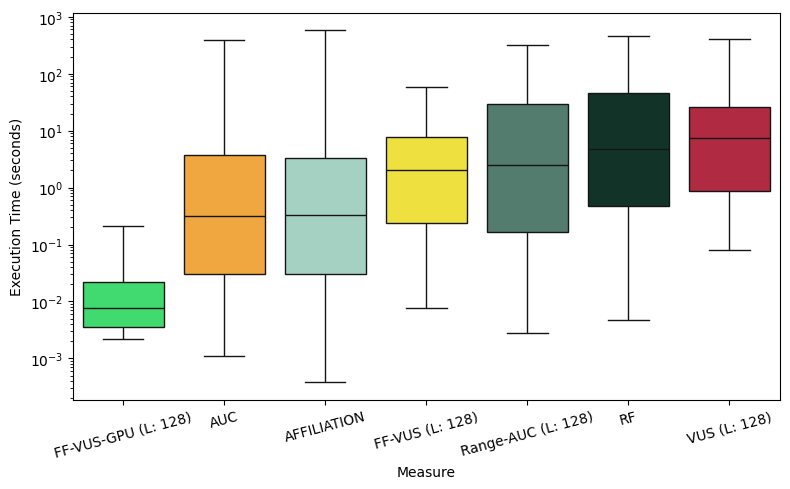

In [6]:
# TODO: Find why there is this big lines per metric, what affects this

# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    saturation=1,
    # showmeans=True, 
    # meanline=True
)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

Total number of time series: 1122
Total number of points: 29749380000, 29749380k, 29749m, 29b
Length min: 1000, max: 1000000000
Number of anomalies min: 1, max: 9006
Anomalies average length min: 1.0, max: 13642.5


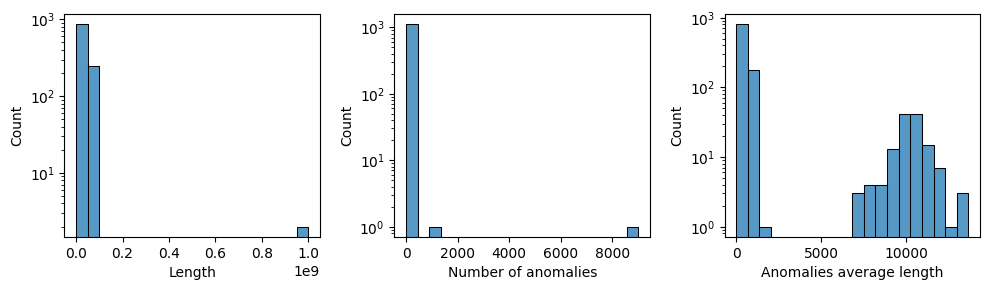

In [7]:
# Synthetic dataset insights
curr_df = df[df['Metric'] == 'AUC']
print(f"Total number of time series: {curr_df.shape[0]}")
print(f"Total number of points: {curr_df['Length'].sum()}, {curr_df['Length'].sum()//10**3}k, {curr_df['Length'].sum()//10**6}m, {curr_df['Length'].sum()//10**9}b")\

attributes = ["Length", "Number of anomalies", "Anomalies average length"]
attr_control = {}
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
bins = 20
for attr, axis in zip(attributes, ax):
    print(f"{attr} min: {curr_df[attr].min()}, max: {curr_df[attr].max()}")
    fig = sns.histplot(x=attr, data=curr_df, ax=axis, bins=bins)
    axis.set_yscale('log')
    axis.set_xlabel(attr)
plt.tight_layout()
plt.show()

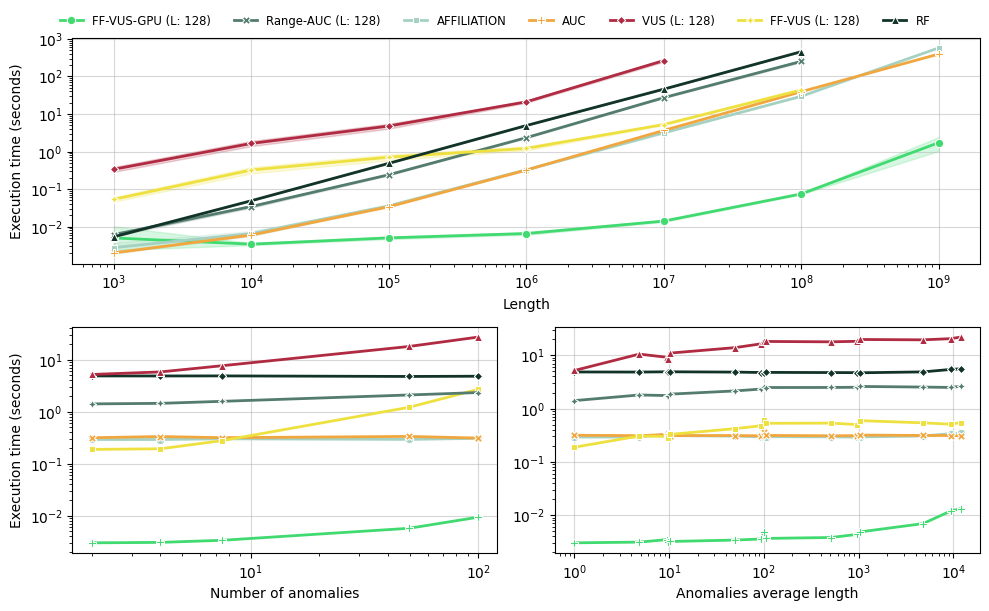

In [14]:
# TODO: Marker size increase
bins = 20
attr_control = {}
legend_axis = None
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    df[f'{attr} bin'] = pd.qcut(df[attr], q=bins, duplicates='drop')
    attr_control[attr] = df[f'{attr} bin'].value_counts().idxmax()

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4),
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])

    mask = pd.Series(True, index=df.index)
    if attribute != 'Length':
        for attr in attributes:
            if attr != attribute:
                mask &= (df[f'{attr} bin'] == attr_control[attr])
    curr_df = df[mask]
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )
  
    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center' if attribute != 'Length' else 'Length',
        y='Metric time',
        hue='Metric',
        data=grouped if attribute != 'Length' else curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=2,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis


handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

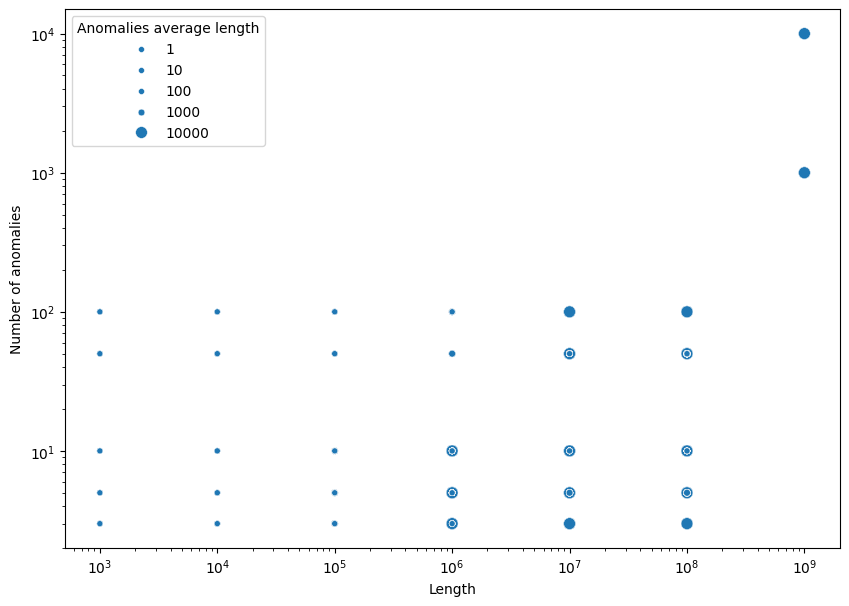

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

sns.scatterplot(
    data=df,
    x='Length',
    y='Number of anomalies',
    size='Anomalies average length',
    ax=ax
)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [73]:
tqdm.pandas()
def fix_ts_stats(row):
    parts = row['Time series'].split('_')
    row['Length'] = int(parts[1])
    row['Number of anomalies'] = int(parts[2])
    row['Anomalies average length'] = int(parts[3])
    row['Contamination'] = float((row['Number of anomalies'] * row['Anomalies average length']) / row['Length'])
    return row

df = df.progress_apply(fix_ts_stats, axis=1)
df

100%|█████████████████████████████████████| 7105/7105 [00:00<00:00, 9343.48it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Precision recall curve time,Integral time,Metric,Metric value,Metric time,Anomaly Coordinates time,Length bin,Number of anomalies bin,Anomalies average length bin,Contamination
0,syn_10000000_3_100_5.npy,10000000,3,100,128.0,1.0,True,function,True,dynamic_plus,...,0.000105,0.000051,FF-VUS-GPU (L: 128),0.813047,0.011653,NaN,"(1000000.0, 10000000.0]","(0.999, 3.0]","(110.2, 913.0]",0.00003
1,syn_10000000_3_100_0.npy,10000000,3,100,128.0,1.0,True,function,True,dynamic_plus,...,0.000101,0.000046,FF-VUS-GPU (L: 128),0.999247,0.009579,NaN,"(1000000.0, 10000000.0]","(0.999, 3.0]","(10.453, 89.333]",0.00003
2,syn_10000000_3_100_2.npy,10000000,3,100,128.0,1.0,True,function,True,dynamic_plus,...,0.000109,0.000052,FF-VUS-GPU (L: 128),0.896742,0.012220,NaN,"(1000000.0, 10000000.0]","(0.999, 3.0]","(110.2, 913.0]",0.00003
3,syn_10000000_3_100_6.npy,10000000,3,100,128.0,1.0,True,function,True,dynamic_plus,...,0.000107,0.000047,FF-VUS-GPU (L: 128),0.847397,0.011089,NaN,"(1000000.0, 10000000.0]","(0.999, 3.0]","(98.288, 102.667]",0.00003
4,syn_10000000_3_100_7.npy,10000000,3,100,128.0,1.0,True,function,True,dynamic_plus,...,0.000098,0.000046,FF-VUS-GPU (L: 128),0.996245,0.011424,NaN,"(1000000.0, 10000000.0]","(0.999, 3.0]","(102.667, 110.2]",0.00003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7100,syn_10000000_100_10000_9.npy,10000000,100,10000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,RF,0.000000,48.588365,NaN,"(1000000.0, 10000000.0]","(90.0, 99.0]","(8506.24, 10299.125]",0.10000
7101,syn_10000000_100_10000_5.npy,10000000,100,10000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,RF,0.000000,48.578418,NaN,"(1000000.0, 10000000.0]","(90.0, 99.0]","(8506.24, 10299.125]",0.10000
7102,syn_10000000_100_10000_3.npy,10000000,100,10000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,RF,0.000000,48.363755,NaN,"(1000000.0, 10000000.0]","(50.0, 90.0]","(8506.24, 10299.125]",0.10000
7103,syn_10000000_100_10000_0.npy,10000000,100,10000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,RF,0.000000,48.840040,NaN,"(1000000.0, 10000000.0]","(50.0, 90.0]","(10299.125, 13642.5]",0.10000


In [78]:
metrics = df['Metric'].unique()
contamination_values = np.sort(df['Contamination'].unique())[::-1]
length_mean_values = []
global_cont_values = [x for x in contamination_values]

for metric in metrics:
    curr_df = df[df['Metric'] == metric]
    length_values = np.sort(curr_df['Length'].unique())
    # print(f"For {metric}, {len(length_values)} lengths were computed: {length_values}")

    for length in length_values:
        cont_value_counts = curr_df[curr_df['Length'] == length]['Contamination'].value_counts()
        # if contamination_values[0] not in cont_value_counts.keys():
            
            # print(cont_value_counts.keys())
        for cont_value in global_cont_values:
            if cont_value not in cont_value_counts:
                global_cont_values.remove(cont_value)
            # if cont_value in cont_value_counts:
            #     length_mean_values.append({
            #         'Metric': metric,
            #         'Length': length,
            #         'Contamination': cont_value,
            #         'Mean execution time': curr_df[np.logical_and(curr_df['Length'] == length, curr_df['Contamination'] == cont_value)]['Metric time'].mean()
            #     })
            #     break
            # print(cont_value_counts.keys())
        # print(curr_df[curr_df['Length'] == length].shape)
        # print(cont_values[0.01])
# length_mean_df = pd.DataFrame(length_mean_values)
# print(length_mean_df)
global_cont_values

[]

In [86]:
for attr in ['Length', 'Number of anomalies', 'Anomalies average length', 'Contamination']:
    unique_attr_values = np.sort(df[attr].unique())
    print(f"{attr}: {unique_attr_values}")
# print(attributes)

Length: [      1000      10000     100000    1000000   10000000  100000000
 1000000000]
Number of anomalies: [    3     5    10    50   100  1000 10000]
Anomalies average length: [    1    10   100  1000 10000]
Contamination: [3.e-08 5.e-08 1.e-07 3.e-07 5.e-07 1.e-06 3.e-06 5.e-06 1.e-05 3.e-05
 5.e-05 1.e-04 3.e-04 5.e-04 1.e-03 3.e-03 5.e-03 1.e-02 3.e-02 5.e-02
 1.e-01]


In [14]:

# TODO: Marker size increase
bins = 20
attr_control = {}
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    attr_control[attr] = df[attr].value_counts().idxmax()
attr_control

# attr_axis = {
#     "Length": (2, 1, 1), 
#     "Number of anomalies": (2, 2, 3), 
#     "Anomalies average length": (2, 2, 4)
# }
# fig = plt.figure(figsize=(10, 6))
# for i, attribute in enumerate(attributes):
#     axis = fig.add_subplot(*attr_axis[attribute])

#     mask = pd.Series(True, index=df.index)
#     if attribute != 'Length':
#         for attr in attributes:
#             if attr != attribute:
#                 mask &= (df[f'{attr} bin'] == attr_control[attr])
#     curr_df = df[mask]
    
#     # Group by bin and metric, compute mean
#     grouped = (
#         curr_df
#         .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
#         .mean()
#         .reset_index()
#     )
  
#     # Convert bin to the midpoint for plotting
#     grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

#     # Plot
#     sns.lineplot(
#         x='bin_center' if attribute != 'Length' else 'Length',
#         y='Metric time',
#         hue='Metric',
#         data=grouped if attribute != 'Length' else curr_df,
#         ax=axis,
#         palette=color_palette,
#         markers=True,
#         style='Metric',
#         dashes = False,
#         linewidth=2,
#         # size='Metric', 
#         # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
#     )

#     axis.set_xlabel(attribute)
#     axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
#     axis.set_yscale('log')
#     axis.set_xscale('log')
#     axis.grid(axis='both', alpha=0.5)
#     if i != 0: 
#         axis.get_legend().remove()

# plt.tight_layout()
# plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
# plt.show()

{'Length': 10000000, 'Number of anomalies': 3, 'Anomalies average length': 1}